
# Introduction to TensorFlow

Welcome! Up until now, you've always used Numpy to build neural networks, but this week you'll explore a deep learning framework that allows you to build neural networks more easily. Machine learning frameworks like TensorFlow, PaddlePaddle, Torch, Caffe, Keras, and many others can speed up your machine learning development significantly. TensorFlow 2.6 has made significant improvements over its predecessor, some of which you'll encounter and implement here!

By the end of this assignment, you'll be able to do the following in TensorFlow 2.6:

    Use tf.Variable to modify the state of a variable
    Explain the difference between a variable and a constant
    Apply TensorFlow decorators to speed up code
    Train a Neural Network on a TensorFlow dataset

Programming frameworks like TensorFlow not only cut down on time spent coding, but can also perform optimizations that speed up the code itself.


In [1]:
import h5py
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

In [ ]:
tf.__version__

'2.6.0'

## Basic Optimization with GradientTape

The beauty of TensorFlow 2 is in its simplicity. Basically, all you need to do is implement forward propagation through a computational graph. TensorFlow will compute the derivatives for you, by moving backwards through the graph recorded with GradientTape. All that's left for you to do then is specify the cost function and optimizer you want to use!

When writing a TensorFlow program, the main object to get used and transformed is the tf.Tensor. These tensors are the TensorFlow equivalent of Numpy arrays, i.e. multidimensional arrays of a given data type that also contain information about the computational graph.

Below, you'll use tf.Variable to store the state of your variables. Variables can only be created once as its initial value defines the variable shape and type. Additionally, the dtype arg in tf.Variable can be set to allow data to be converted to that type. But if none is specified, either the datatype will be kept if the initial value is a Tensor, or convert_to_tensor will decide. It's generally best for you to specify directly, so nothing breaks!

You will use the horse or human data set, that is composed of images with shape 300x300x3.

In [17]:
ds, ds_info = tfds.load('horses_or_humans', as_supervised=True, with_info=True)
ds_info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    version=3.0.0,
    description='A large set of images of horses and humans.',
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=1283,
    splits={
        'test': 256,
        'train': 1027,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
    redistribution_info=,
)

,image,label
0,,0 (horses)
1,,0 (horses)
2,,0 (horses)
3,,0 (horses)
4,,0 (horses)
5,,0 (horses)
6,,0 (horses)
7,,1 (humans)
8,,1 (humans)
9,,1 (humans)

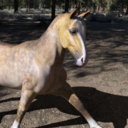
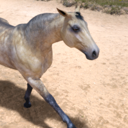
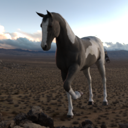
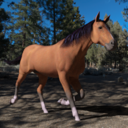
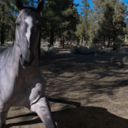
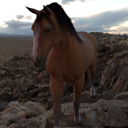
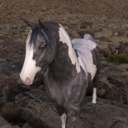
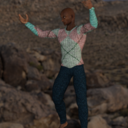
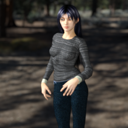
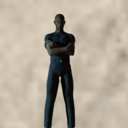

In [101]:
tfds.as_dataframe(ds['train'].take(10), ds_info)

There's one more additional difference between TensorFlow datasets and Numpy arrays: If you need to transform one, you would invoke the map method to apply the function passed as an argument to each of the elements.

In [215]:
def normalize(image, label):
    """
    Transform an image into a tensor of shape (64^2*3, 1)
    and normalize its components.
    
    Arguments
    image - Tensor, label.
    
    Returns: 
    result -- Transformed tensor, label
    """
    image = tf.cast(image, tf.float32) / 256.0
    image = tf.image.resize(image, (64, 64))
    image = tf.reshape(image, [-1,1])
    return image, label

In [216]:
new_train = ds['train'].map(normalize)
new_test = ds['test'].map(normalize)

In [217]:
new_train.element_spec

(TensorSpec(shape=(12288, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [218]:
x_train, y_train, x_test, y_test = [], [], [], []

for img, lab in new_train:
  x_train.append(img)
  y_train.append(lab)

for img, lab in new_test:
  x_test.append(img)
  y_test.append(lab)

x_train = tf.data.Dataset.from_tensor_slices(x_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
x_test = tf.data.Dataset.from_tensor_slices(x_test)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

In [49]:
print(next(iter(x_train)))

tf.Tensor(
[[0.23064804]
 [0.21736908]
 [0.19774246]
 ...
 [0.5646744 ]
 [0.48635864]
 [0.41749573]], shape=(12288, 1), dtype=float32)


2.1 - Linear Function

Let's begin this programming exercise by computing the following equation: $Y = WX + b$, where $W$ and $X$ are random matrices and b is a random vector.

Exercise 1 - linear_function

Compute $WX + b$ where $W, X$, and $b$ are drawn from a random normal distribution. W is of shape (4, 3), X is (3,1) and b is (4,1). As an example, this is how to define a constant X with the shape (3,1):

X = tf.constant(np.random.randn(3,1), name = "X")

Note that the difference between tf.constant and tf.Variable is that you can modify the state of a tf.Variable but cannot change the state of a tf.constant.

In [22]:
def linear_function():
    """
    Implements a linear function: 
            Initializes X to be a random tensor of shape (3,1)
            Initializes W to be a random tensor of shape (4,3)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- Y = WX + b 
    """

    np.random.seed(1)
    
    X = tf.constant(np.random.randn(3, 1), name="X")
    W = tf.Variable(np.random.randn(4, 3), name="W")
    b = tf.Variable(np.random.randn(4, 1), name="b")
    Y = tf.add(tf.matmul(W, X), b)
    
    return Y

In [23]:
result = linear_function()
print(result)

assert type(result) == EagerTensor, "Use the TensorFlow API"
assert np.allclose(result, [[-2.15657382], [ 2.95891446], [-1.08926781], [-0.84538042]]), "Error"
print("\033[92mAll tests passed")

tf.Tensor(
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]], shape=(4, 1), dtype=float64)
All tests passed




2.2 - Computing the Sigmoid

Amazing! You just implemented a linear function. TensorFlow offers a variety of commonly used neural network functions like tf.sigmoid and tf.softmax.

For this exercise, compute the sigmoid of z.

In this exercise, you will: Cast your tensor to type float32 using tf.cast, then compute the sigmoid using tf.keras.activations.sigmoid.

Exercise 2 - sigmoid

Implement the sigmoid function below. You should use the following:

    tf.cast("...", tf.float32)
    tf.keras.activations.sigmoid("...")



In [24]:
def sigmoid(z):
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    a -- (tf.float32) the sigmoid of z
    """
    # tf.keras.activations.sigmoid requires float16, float32, float64, complex64, or complex128.
    
    z = tf.cast(z, tf.float32)
    a = tf.keras.activations.sigmoid(z)

    return a

In [25]:
result = sigmoid(-1)
print ("type: " + str(type(result)))
print ("dtype: " + str(result.dtype))
print ("sigmoid(-1) = " + str(result))
print ("sigmoid(0) = " + str(sigmoid(0.0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

def sigmoid_test(target):
    result = target(0)
    assert(type(result) == EagerTensor)
    assert (result.dtype == tf.float32)
    assert sigmoid(0) == 0.5, "Error"
    assert sigmoid(-1) == 0.26894143, "Error"
    #assert sigmoid(12) == 0.9999939, "Error"

    print("\033[92mAll tests passed")

sigmoid_test(sigmoid)

type: <class 'tensorflow.python.framework.ops.EagerTensor'>
dtype: <dtype: 'float32'>
sigmoid(-1) = tf.Tensor(0.26894143, shape=(), dtype=float32)
sigmoid(0) = tf.Tensor(0.5, shape=(), dtype=float32)
sigmoid(12) = tf.Tensor(0.9999938, shape=(), dtype=float32)
All tests passed


2.3 - Using One Hot Encodings

Many times in deep learning you will have a $Y$ vector with numbers ranging from $0$ to $C-1$, where $C$ is the number of classes. If $C$ is for example 4, then you might have the following y vector which you will need to convert like this:

This is called "one hot" encoding, because in the converted representation, exactly one element of each column is "hot" (meaning set to 1). To do this conversion in numpy, you might have to write a few lines of code. In TensorFlow, you can use one line of code:

    tf.one_hot(labels, depth, axis=0)

axis=0 indicates the new axis is created at dimension 0

Exercise 3 - one_hot_matrix

Implement the function below to take one label and the total number of classes $C$, and return the one hot encoding in a column wise matrix. Use tf.one_hot() to do this, and tf.reshape() to reshape your one hot tensor!

    tf.reshape(tensor, shape)


In [258]:
def one_hot_matrix(label, depth=2):
    """
    Computes the one hot encoding for a single label
    
    Arguments:
        label --  (int) Categorical labels
        depth --  (int) Number of different classes that label can take
    
    Returns:
         one_hot -- tf.Tensor A single-column matrix with the one hot encoding.
    """
    # dimension is (category classes x 1)
    one_hot = tf.reshape(tf.one_hot(label, depth), (depth, 1))
    
    return one_hot

In [259]:
def one_hot_matrix_test(target):
    label = tf.constant(1)
    depth = 4
    result = target(label, depth)
    print(result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert result.shape[1] == 1, f"Reshape to have only 1 column"
    assert np.allclose(result,  [[0.], [1.], [0.], [0.]] ), "Wrong output. Use tf.one_hot"
    result = target(3, depth)
    assert np.allclose(result, [[0.], [0.], [0.], [1.]] ), "Wrong output. Use tf.one_hot"
    
    print("\033[92mAll test passed")

one_hot_matrix_test(one_hot_matrix)

tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]], shape=(4, 1), dtype=float32)
All test passed


We're using two output units to make use of one-hot encoding but in reality, only one is needed for a binary classification problem.

In [260]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

In [261]:
print(next(iter(new_y_test)))

tf.Tensor(
[[1.]
 [0.]], shape=(2, 1), dtype=float32)


2.4 - Initialize the Parameters

Now you'll initialize a vector of numbers between zero and one. The function you'll be calling is tf.keras.initializers.GlorotNormal, which draws samples from a truncated normal distribution centered on 0, with stddev = sqrt(2 / (fan_in + fan_out)), where fan_in is the number of input units and fan_out is the number of output units, both in the weight tensor.

To initialize with zeros or ones you could use tf.zeros() or tf.ones() instead.

Exercise 4 - initialize_parameters

Implement the function below to take in a shape and to return an array of numbers between -1 and 1.

    tf.keras.initializers.GlorotNormal(seed=1)
    tf.Variable(initializer(shape=())


In [262]:
def initialize_parameters(height=64):
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [25, x]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [2, 12]
                        b3 : [2, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """                           
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   
    
    # layer 1
    W1 = tf.Variable(initializer(shape=(25, height**2*3)), name="W1")
    b1 = tf.Variable(initializer(shape=(25, 1)), name="b1")
    
    # layer 2
    W2 = tf.Variable(initializer(shape=(12, 25)), name="W2")
    b2 = tf.Variable(initializer(shape=(12, 1)), name="b2")
    
    # layer 3
    W3 = tf.Variable(initializer(shape=(2, 12)), name="W3")
    b3 = tf.Variable(initializer(shape=(2, 1)), name="b3")

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [263]:
def initialize_parameters_test(target):
    parameters = target()

    values = {"W1": (25, 64**2*3),
              "b1": (25, 1),
              "W2": (12, 25),
              "b2": (12, 1),
              "W3": (2, 12),
              "b3": (2, 1)}

    for key in parameters:
        print(f"{key} shape: {tuple(parameters[key].shape)}")
        assert type(parameters[key]) == ResourceVariable, "All parameter must be created using tf.Variable"
        assert np.abs(np.mean(parameters[key].numpy())) < 0.5,  f"{key}: Use the GlorotNormal initializer"
        assert np.std(parameters[key].numpy()) > 0 and np.std(parameters[key].numpy()) < 1, f"{key}: Use the GlorotNormal initializer"

    print("\033[92mAll test passed")
    
initialize_parameters_test(initialize_parameters)

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (2, 12)
b3 shape: (2, 1)
All test passed


In [264]:
parameters = initialize_parameters()

3 - Building Your First Neural Network in TensorFlow

In this part of the assignment you will build a neural network using TensorFlow. Remember that there are two parts to implementing a TensorFlow model:

    Implement forward propagation
    Retrieve the gradients and train the model

Let's get into it!

3.1 - Implement Forward Propagation

One of TensorFlow's great strengths lies in the fact that you only need to implement the forward propagation function.

Here, you'll use a TensorFlow decorator, @tf.function, which builds a computational graph to execute the function. @tf.function is polymorphic, which comes in very handy, as it can support arguments with different data types or shapes, and be used with other languages, such as Python. This means that you can use data dependent control flow statements.

When you use @tf.function to implement forward propagation, the computational graph is activated, which keeps track of the operations. This is so you can calculate your gradients with backpropagation.

Exercise 5 - forward_propagation

Implement the forward_propagation function.

Note Use only the TF API.

    tf.math.add
    tf.linalg.matmul
    tf.keras.activations.relu



In [265]:
@tf.function        # <---- tf decorator
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Numpy Equivalents:
    # Z1 = np.dot(W1, X) + b1
    # A1 = relu(Z1)
    # Z2 = np.dot(W2, A1) + b2
    # A2 = relu(Z2)
    # Z3 = np.dot(W3, A2) + b3
    
    # layer 1
    Z1 = tf.math.add(tf.linalg.matmul(W1, X), b1)
    A1 = tf.keras.activations.relu(Z1)
    
    # layer 2
    Z2 = tf.math.add(tf.linalg.matmul(W2, A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    
    # layer 3
    Z3 = tf.math.add(tf.linalg.matmul(W3, A2), b3)
    
    return Z3

In [267]:
def forward_propagation_test(target, examples):
    for batch in examples:
        forward_pass = target(batch, parameters)
        assert type(forward_pass) == EagerTensor, "Your output is not a tensor"
        assert forward_pass.shape == (2, 1), "Last layer must use W3 and b3"
        assert np.any(forward_pass < 0), "Don't use a ReLu layer at end of your network"
        #assert np.allclose(forward_pass, 
                           #[[-0.13082162],
                           #[ 0.21228778],
                           #[ 0.7050022 ],
                           #[-1.1224034 ],
                           #[-0.20386729],
                           #[ 0.9526217 ]]), "Output does not match"
        print(forward_pass)
        break
    print("\033[92mAll test passed")

forward_propagation_test(forward_propagation, x_train)

tf.Tensor(
[[ 0.31692123]
 [-0.4408256 ]], shape=(2, 1), dtype=float32)
All test passed


3.2 Compute the Cost

Here again, the delightful @tf.function decorator steps in and saves you time. All you need to do is specify how to compute the cost, and you can do so in one simple step by using:

tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true = ..., y_pred = ..., from_logits=True))

Exercise 6 - compute_cost

Implement the cost function below.

    It's important to note that the "y_pred" and "y_true" inputs of tf.keras.losses.binary_crossentropy are expected to be of shape (number of examples, num_classes). Since both the transpose and the original tensors have the same values, just in different order, the result of calculating the binary_crossentropy should be the same if you transpose or not the logits and labels. Just for reference here is how the Binary Cross entropy is calculated in TensorFlow:

mean_reduce(max(logits, 0) - logits * labels + log(1 + exp(-abs(logits))), axis=-1)

    tf.reduce_mean basically does the summation over the examples.


In [268]:
@tf.function
def compute_cost(logits, labels):
    """
    Computes the cost
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    labels -- "true" labels vector, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true=labels, y_pred=logits, from_logits=True))

    return cost

In [269]:
def compute_cost_test(target):
    labels = np.array([[0., 1.], [0., 0.], [1., 0.]])
    logits = np.array([[0.6, 0.4], [0.4, 0.6], [0.4, 0.6]])
    result = compute_cost(logits, labels)
    print(result)
    assert(type(result) == EagerTensor), "Use the TensorFlow API"
    assert (np.abs(result - (0.7752516 +  0.9752516 + 0.7752516) / 3.0) < 1e-7), "Test does not match. Did you get the mean of your cost functions?"

    print("\033[92mAll test passed")

compute_cost_test(compute_cost)

tf.Tensor(0.8419182681095857, shape=(), dtype=float64)
All test passed


3.3 - Train the Model

Let's talk optimizers. You'll specify the type of optimizer in one line, in this case tf.keras.optimizers.Adam (though you can use others such as SGD), and then call it within the training loop.

Notice the tape.gradient function: this allows you to retrieve the operations recorded for automatic differentiation inside the GradientTape block. Then, calling the optimizer method apply_gradients, will apply the optimizer's update rules to each trainable parameter. At the end of this assignment, you'll find some documentation that explains this more in detail, but for now, a simple explanation will do. ;)

Here you should take note of an important extra step that's been added to the batch training process:

    tf.Data.dataset = dataset.prefetch(8)

What this does is prevent a memory bottleneck that can occur when reading from disk. prefetch() sets aside some data and keeps it ready for when it's needed. It does this by creating a source dataset from your input data, applying a transformation to preprocess the data, then iterating over the dataset the specified number of elements at a time. This works because the iteration is streaming, so the data doesn't need to fit into the memory.

In [356]:
def model(X_train, Y_train, learning_rate = 0.0001,
          num_epochs = 100, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []         # To keep track of the cost
    
    # Initialize your parameters
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    optimizer = tf.keras.optimizers.SGD(learning_rate)

    X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # Do the training loop
    for epoch in range(num_epochs):

        epoch_cost = 0.
        
        for (minibatch_X, minibatch_Y) in zip(X_train, Y_train):
            # Select a minibatch
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(minibatch_X, parameters)
                # 2. loss
                minibatch_cost = compute_cost(Z3, minibatch_Y)
                
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += minibatch_cost / minibatch_size

        # Print the cost every epoch
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)

    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    # Save the parameters in a variable
    print ("Parameters have been trained!")

    return parameters

I used up to a few thousand epochs and it didn't seem to help on test data. Gradients bounced around on learning rates above .001 and ended up badly overfitting training data so that training cost was near zero but performance on test data declined.

Cost after epoch 0: 0.653476
Cost after epoch 10: 0.495447
Cost after epoch 20: 0.415474
Cost after epoch 30: 0.354608
Cost after epoch 40: 0.305956
Cost after epoch 50: 0.266153
Cost after epoch 60: 0.233618
Cost after epoch 70: 0.206658
Cost after epoch 80: 0.184054
Cost after epoch 90: 0.164843


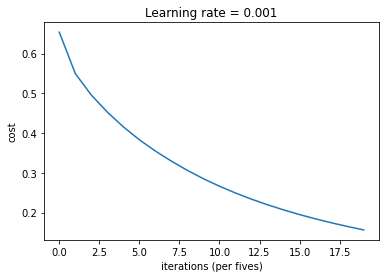

Parameters have been trained!


In [372]:
params = model(x_train, new_y_train, num_epochs = 100, learning_rate = 0.001)

4 - Predict on test data

The test data was reshaped and resized at the top of this notebook using the normalize function. Here we look at the predictions from trained parameters for W1, b1, W2, b2, W3, and b3. We will reuse the forward propogation function we used to train the model and compare the output to the previously one-hot encoded labels.

,image,label
0,,0 (horses)
1,,0 (horses)
2,,0 (horses)
3,,1 (humans)
4,,1 (humans)

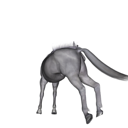
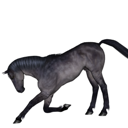
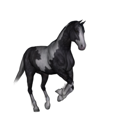
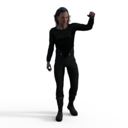
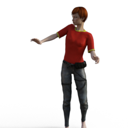

In [193]:
#the first few items from the test set
tfds.as_dataframe(ds['test'].take(5), ds_info)

In [392]:
y_true_tensors, y_pred_tensors = list(new_y_test), []

for x in x_test: #normalized data
  Z3 = forward_propagation(x, params)
  y_pred_tensors.append(sigmoid(Z3))

y_pred = np.argmax(np.array(y_pred_tensors), axis=1).reshape(1,-1)[0]
y_true = np.argmax(np.array(y_true_tensors), axis=1).reshape(1,-1)[0]

After applying the sigmoid activation function, the dual output units can be interpreted probabilities of the 0 (horse) class and the 1 (human) class. The model is not very confident about the 1st horse observation and very confident about the 2nd horse observation. It turns out the model makes 41/44 errors on photos of horses and has a classification accuracy of 83 percent.

I can understand this. A human can't look like a quadraped easily but a horse viewed head-on can look like a biped. I wonder what humans looked like horses...

In [393]:
m = len(y_true)
errors = np.sum(np.abs(y_true - y_pred))
human_errors = np.sum((y_true - y_pred) == 1)
horse_errors = np.sum((y_true - y_pred) == -1)

print(f"{human_errors} errors on human photos, {horse_errors} errors on horse photos")
print(f"test accuracy: {(m-errors)/m}")

3 errors on human photos, 41 errors on horse photos
test accuracy: 0.828125


In [394]:
#a look at 'confidence' of predictions
for ix in range(3): print(y_pred_tensors[ix], y_true_tensors[ix])

tf.Tensor(
[[0.54520124]
 [0.3915084 ]], shape=(2, 1), dtype=float32) tf.Tensor(
[[1.]
 [0.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.9877182 ]
 [0.03698093]], shape=(2, 1), dtype=float32) tf.Tensor(
[[1.]
 [0.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.6116521 ]
 [0.43918532]], shape=(2, 1), dtype=float32) tf.Tensor(
[[1.]
 [0.]], shape=(2, 1), dtype=float32)


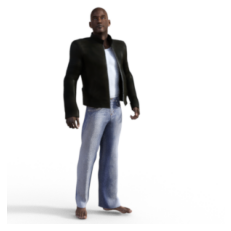

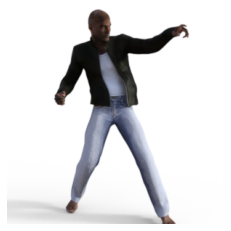

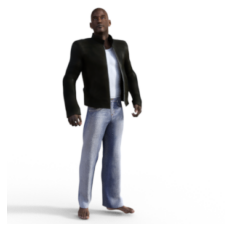

In [421]:
#where horses look like humans, cuz im black? lol
idx = np.argwhere((y_true - y_pred) == 1).reshape(1,-1)[0]

for ix, img in enumerate(ds['test']):
  if ix in idx:
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()

In [376]:
# Save
path="/content/drive/MyDrive/galvanize/"
np.save(path+'my_file.npy', params) 
# Load
params = np.load(path+'my_file.npy', allow_pickle='TRUE').item()



Congratulations! Amazing work building a neural network in TensorFlow 2.6!

Here's a quick recap of all you just achieved:

    Used tf.Variable to modify your variables
    Applied TensorFlow decorators and observed how they sped up your code
    Trained a Neural Network on a TensorFlow dataset

You are now able to harness the power of TensorFlow's computational graph to create cool things, faster. Nice!


4 - Bibliography

In this assignment, you were introducted to tf.GradientTape, which records operations for differentation. Here are a couple of resources for diving deeper into what it does and why:

Introduction to Gradients and Automatic Differentiation: https://www.tensorflow.org/guide/autodiff

GradientTape documentation: https://www.tensorflow.org/api_docs/python/tf/GradientTape